In [1]:
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Input, RepeatVector, Dropout
from keras.layers import Reshape, concatenate, Conv2DTranspose, UpSampling2D, Convolution2D
from sklearn.metrics import f1_score
from keras import optimizers, callbacks
from scipy import stats
import numpy as np
import keras
import cv2

from common import Metrics

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

INPUT_SIZE = (512, 512)

In [3]:
def preprocess_img(filepath, test_img=False):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, INPUT_SIZE)
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    if test_img:
        img_resized = np.expand_dims(img_resized, 3)
        img_resized = (img_resized / 255).astype(np.float32)
    else:
        img_resized = np.expand_dims(img_resized, axis=3)
        img_resized = img_resized.astype(np.float32)
        for i in range(len(img_resized.shape)):  # Mean subtraction
            img_resized[i] -= np.mean(img_resized[i])
        
    return img_resized

files = os.listdir(X_IMG_PATH)
original = [cv2.imread(X_IMG_PATH + fname) for fname in files]
images_all = np.array([preprocess_img(X_IMG_PATH + fname) for fname in files])
labels_all = np.array([preprocess_img(Y_IMG_PATH + fname, True) for fname in files])

/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # Remove the CWD from sys.path while we load stuff.
/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys


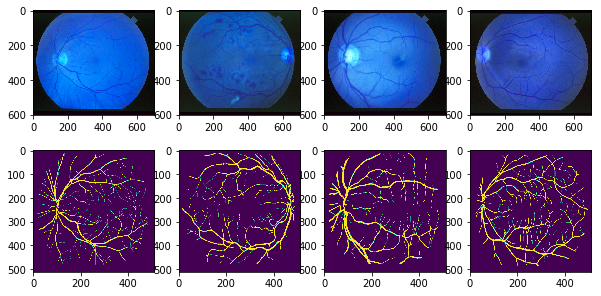

In [4]:
N_SHOW = 4  # How many examples should be shown
f, axarr = plt.subplots(2, N_SHOW, figsize=(10,5))

for i in range(N_SHOW):
    axarr[0, i].imshow(original[i])
    axarr[1, i].imshow(labels_all[i,:,:,0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_all,
                                                    labels_all,
                                                    test_size=0.25)
X_train.shape, X_test.shape

((15, 512, 512, 1), (5, 512, 512, 1))

In [6]:
# Source: https://www.kaggle.com/bguberfain/unet-with-depth
input_img = Input((*INPUT_SIZE, 1), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

optimizer = optimizers.Adam(lr=1e-5)
model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
model.fit(X_train, y_train,
          batch_size=5, epochs=50,
          validation_data=(X_test, y_test),
          callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 15 samples, validate on 5 samples
Epoch 1/50
15/15 [==============================] - 4s 288ms/step - loss: 0.6582 - acc: 0.5875 - val_loss: 0.5368 - val_acc: 0.8606
Epoch 2/50
15/15 [==============================] - 0s 21ms/step - loss: 0.5023 - acc: 0.8739 - val_loss: 0.4240 - val_acc: 0.8948
Epoch 3/50
15/15 [==============================] - 0s 20ms/step - loss: 0.4082 - acc: 0.8966 - val_loss: 0.3791 - val_acc: 0.8996
Epoch 4/50
15/15 [==============================] - 0s 21ms/step - loss: 0.3786 - acc: 0.8994 - val_loss: 0.4002 - val_acc: 0.9001
Epoch 5/50
15/15 [==============================] - 0s 21ms/step - loss: 0.3852 - acc: 0.8996 - val_loss: 0.3986 - val_acc: 0.9002
Epoch 6/50
15/15 [==============================] - 0s 21ms/step - loss: 0.3785 - acc: 0.8996 - val_loss: 0.3763 - val_acc: 0.9002
Epoch 7/50
15/15 [==============================] - 0s 21ms/step - loss: 0.3547 - acc: 0.8996 - val_loss: 0.3412 - val_acc

In [9]:
def process_predictions(y_pred):
    new_shape = (y_pred.shape[0], *INPUT_SIZE)
    y_proc = np.reshape(y_pred, new_shape)
    y_proc = y_proc / y_proc.max()
    y_proc = y_proc > .3
    return y_proc

# Process ground truth samples
y_true_proc = process_predictions(y_test)

# Predict and process testset
y_pred = model.predict(X_test)
y_pred_proc = process_predictions(y_pred)

In [10]:
y_preds, y_trues = [], []
scores_all = []

for y_true, y_pred in zip(y_true_proc, y_pred_proc):
    scores = Metrics()
    scores.calculate(y_true.ravel(), y_pred.ravel())
    
    y_preds.append(y_pred)
    y_trues.append(y_true)
    scores_all.append(scores)
    
    print(scores)

Acc: 0.93084, sensitivity: 0.68958, specificity: 0.95730, F1-score: 0.66342
Acc: 0.92740, sensitivity: 0.05966, specificity: 0.99530, F1-score: 0.10657
Acc: 0.92864, sensitivity: 0.74880, specificity: 0.94638, F1-score: 0.65325
Acc: 0.94281, sensitivity: 0.58001, specificity: 0.96854, F1-score: 0.57326
Acc: 0.93824, sensitivity: 0.50363, specificity: 0.98446, F1-score: 0.61055


In [11]:
metrics_overview = Metrics.mean_metric(scores_all)
print('Mean metrics for {} samples:'.format(len(y_trues)))
print(metrics_overview)

Mean metrics for 5 samples:
Acc: 0.93359, sensitivity: 0.51634, specificity: 0.97040, F1-score: 0.52141


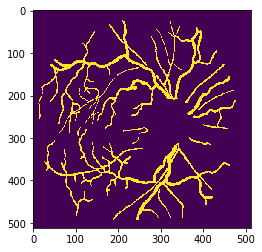

In [12]:
plt.imshow(y_true_proc[0])

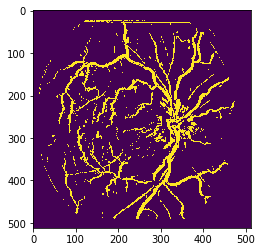

In [13]:
plt.imshow(y_pred_proc[0])

In [14]:
y_hat_proc[0].shape

NameError: name 'y_hat_proc' is not defined